<a href="https://colab.research.google.com/github/carwilfer/Projeto-IoT-e-Data-Science/blob/main/Carlos_Ferreira_PB_IOT_TP7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pmdarima

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import pytz
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima
from pmdarima.arima.stationarity import ADFTest
from sklearn.metrics import mean_squared_error, r2_score
from fbprophet import Prophet

In [ ]:
df_NYC_Motor = pd.read_csv('NYC_Motor.csv')
df_NYC_Motor

In [ ]:
df_NYC_Motor.describe()

In [ ]:
df_NYC_Motor.info()

In [ ]:
df_NYC_Motor.columns

In [ ]:
df_NYC_Motor.columns.values

In [ ]:
df_NYC_Motor.T

In [ ]:
df_NYC_util = df_NYC_Motor.loc[:,["CRASH_DATE", "CRASH_TIME", "PERSON_INJURY", "PERSON_AGE", "PERSON_SEX", "PERSON_TYPE", "COMPLAINT", "EMOTIONAL_STATUS", "COLLISION_ID"]].set_index('CRASH_DATE')
df_NYC_util

,CRASH_TIME,PERSON_INJURY,PERSON_AGE,PERSON_SEX,PERSON_TYPE,COMPLAINT,EMOTIONAL_STATUS,COLLISION_ID
CRASH_DATE,,,,,,,,
2021-05-02,21:00,Killed,62.0,F,Pedestrian,Severe Bleeding,Apparent Death,4412948
2021-05-21,0:00,Killed,24.0,M,Occupant,Internal,Apparent Death,4419608
2021-10-15,2:00,Killed,30.0,M,Occupant,Internal,Apparent Death,4467504
2021-04-17,13:00,Killed,71.0,M,Pedestrian,Internal,Unconscious,4408062
2021-05-25,22:00,Killed,69.0,F,Pedestrian,None Visible,Conscious,4420918
...,...,...,...,...,...,...,...,...
2021-05-07,0:00,Injured,24.0,M,Occupant,Complaint of Pain or Nausea,Conscious,4414130
2021-04-27,13:00,Injured,29.0,M,Occupant,Complaint of Pain or Nausea,Conscious,4411119
2021-05-07,14:00,Injured,7.0,F,Occupant,Complaint of Pain or Nausea,Conscious,4415414


In [ ]:
df_NYC_util.info()

<class 'pandas.core.frame.DataFrame'>
Index: 45669 entries, 2021-05-02 to 2021-11-09
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   CRASH_TIME        45669 non-null  object 
 1   PERSON_INJURY     45669 non-null  object 
 2   PERSON_AGE        45248 non-null  float64
 3   PERSON_SEX        45669 non-null  object 
 4   PERSON_TYPE       45669 non-null  object 
 5   COMPLAINT         45669 non-null  object 
 6   EMOTIONAL_STATUS  45669 non-null  object 
 7   COLLISION_ID      45669 non-null  int64  
dtypes: float64(1), int64(1), object(6)
memory usage: 3.1+ MB


In [ ]:
df_NYC_util.dropna(inplace=True)

In [ ]:
df_NYC_util.isna().sum()

CRASH_TIME          0
PERSON_INJURY       0
PERSON_AGE          0
PERSON_SEX          0
PERSON_TYPE         0
COMPLAINT           0
EMOTIONAL_STATUS    0
COLLISION_ID        0
dtype: int64

In [ ]:
#df_NYC_Motor.sort_values(by=['CRASH_DATE','PERSON_AGE'], ascending=[True,False])
df_NYC_util.sort_values(by = 'CRASH_DATE', ascending=True)

,CRASH_TIME,PERSON_INJURY,PERSON_AGE,PERSON_SEX,PERSON_TYPE,COMPLAINT,EMOTIONAL_STATUS,COLLISION_ID
CRASH_DATE,,,,,,,,
2021-01-01,11:00,Injured,38.0,M,Occupant,Internal,Conscious,4381163
2021-01-01,1:00,Injured,20.0,M,Pedestrian,Contusion - Bruise,Conscious,4380810
2021-01-01,4:00,Injured,21.0,M,Occupant,Complaint of Pain or Nausea,Conscious,4381028
2021-01-01,4:00,Injured,29.0,M,Occupant,Complaint of Pain or Nausea,Conscious,4380928
2021-01-01,6:00,Injured,18.0,F,Occupant,Complaint of Pain or Nausea,Shock,4380756
...,...,...,...,...,...,...,...,...
2021-11-16,8:00,Injured,40.0,M,Bicyclist,Complaint of Pain or Nausea,Conscious,4477923
2021-11-16,9:00,Injured,34.0,M,Occupant,Complaint of Pain or Nausea,Conscious,4477998
2021-11-16,7:00,Injured,21.0,M,Other Motorized,Complaint of Pain or Nausea,Conscious,4478377


In [ ]:
df_NYC_util.reset_index(inplace=True)
crash_datetime = df_NYC_util['CRASH_DATE'] + " "+ df_NYC_util['CRASH_TIME']
df_NYC_util["CRASH_DATETIME"] = pd.to_datetime(crash_datetime)
df_NYC_util.set_index("CRASH_DATETIME", inplace=True)
df_NYC_util

,CRASH_DATE,CRASH_TIME,PERSON_INJURY,PERSON_AGE,PERSON_SEX,PERSON_TYPE,COMPLAINT,EMOTIONAL_STATUS,COLLISION_ID
CRASH_DATETIME,,,,,,,,,
2021-05-02 21:00:00,2021-05-02,21:00,Killed,62.0,F,Pedestrian,Severe Bleeding,Apparent Death,4412948
2021-05-21 00:00:00,2021-05-21,0:00,Killed,24.0,M,Occupant,Internal,Apparent Death,4419608
2021-10-15 02:00:00,2021-10-15,2:00,Killed,30.0,M,Occupant,Internal,Apparent Death,4467504
2021-04-17 13:00:00,2021-04-17,13:00,Killed,71.0,M,Pedestrian,Internal,Unconscious,4408062
2021-05-25 22:00:00,2021-05-25,22:00,Killed,69.0,F,Pedestrian,None Visible,Conscious,4420918
...,...,...,...,...,...,...,...,...,...
2021-05-07 00:00:00,2021-05-07,0:00,Injured,24.0,M,Occupant,Complaint of Pain or Nausea,Conscious,4414130
2021-04-27 13:00:00,2021-04-27,13:00,Injured,29.0,M,Occupant,Complaint of Pain or Nausea,Conscious,4411119
2021-05-07 14:00:00,2021-05-07,14:00,Injured,7.0,F,Occupant,Complaint of Pain or Nausea,Conscious,4415414


In [ ]:
df_NYC_util.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 45248 entries, 2021-05-02 21:00:00 to 2021-11-09 13:00:00
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   CRASH_DATE        45248 non-null  object 
 1   CRASH_TIME        45248 non-null  object 
 2   PERSON_INJURY     45248 non-null  object 
 3   PERSON_AGE        45248 non-null  float64
 4   PERSON_SEX        45248 non-null  object 
 5   PERSON_TYPE       45248 non-null  object 
 6   COMPLAINT         45248 non-null  object 
 7   EMOTIONAL_STATUS  45248 non-null  object 
 8   COLLISION_ID      45248 non-null  int64  
dtypes: float64(1), int64(1), object(7)
memory usage: 3.5+ MB


In [ ]:
df_NYC_util["PERSON_INJURY"].nunique()

2

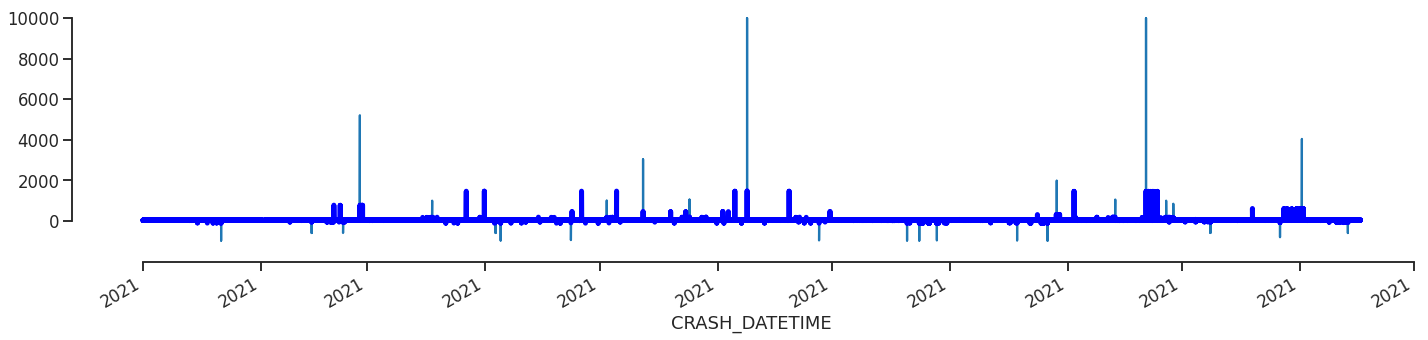

In [ ]:
def plot_series(series):
    sns.set_context("talk")
    sns.set_style("ticks")

    fig, ax = plt.subplots(1, 1, figsize=(24, 5))
    ax = series.plot(ax = ax)
    ax.yaxis.grid(True)
    sns.despine(offset=10, trim=True)
    return ax

ax = plot_series(df_NYC_util.PERSON_AGE)
df_NYC_util.PERSON_AGE.rolling(7).mean().plot(ax=ax, c='b', lw=5)

In [ ]:
df_NYC_sitacao = df_NYC_util['PERSON_INJURY']
df_NYC_sitacao

CRASH_DATETIME
2021-05-02 21:00:00     Killed
2021-05-21 00:00:00     Killed
2021-10-15 02:00:00     Killed
2021-04-17 13:00:00     Killed
2021-05-25 22:00:00     Killed
                        ...   
2021-05-07 00:00:00    Injured
2021-04-27 13:00:00    Injured
2021-05-07 14:00:00    Injured
2021-05-10 16:00:00    Injured
2021-11-09 13:00:00    Injured
Name: PERSON_INJURY, Length: 45248, dtype: object

In [ ]:
df_NYC_util.iloc[:,4]

CRASH_DATETIME
2021-05-02 21:00:00    F
2021-05-21 00:00:00    M
2021-10-15 02:00:00    M
2021-04-17 13:00:00    M
2021-05-25 22:00:00    F
                      ..
2021-05-07 00:00:00    M
2021-04-27 13:00:00    M
2021-05-07 14:00:00    F
2021-05-10 16:00:00    F
2021-11-09 13:00:00    M
Name: PERSON_SEX, Length: 45248, dtype: object

In [ ]:
label_encoder_teste = LabelEncoder()
df_NYC_util.iloc[:,2]
df_NYC_util.iloc[:,4]
teste = label_encoder_teste.fit_transform(df_NYC_util.iloc[:,2])
teste_2 = label_encoder_teste.fit_transform(df_NYC_util.iloc[:,4])

In [ ]:
teste

array([1, 1, 1, ..., 0, 0, 0])

In [ ]:
teste_2

array([0, 1, 1, ..., 0, 0, 1])

In [ ]:
df_NYC_util["PERSON_INJURY_BIN"] = teste
df_NYC_util["PERSON_SEX_BIN"] = teste_2
df_NYC_util

,CRASH_DATE,CRASH_TIME,PERSON_INJURY,PERSON_AGE,PERSON_SEX,PERSON_TYPE,COMPLAINT,EMOTIONAL_STATUS,COLLISION_ID,PERSON_INJURY_BIN,PERSON_SEX_BIN
CRASH_DATETIME,,,,,,,,,,,
2021-05-02 21:00:00,2021-05-02,21:00,Killed,62.0,F,Pedestrian,Severe Bleeding,Apparent Death,4412948,1,0
2021-05-21 00:00:00,2021-05-21,0:00,Killed,24.0,M,Occupant,Internal,Apparent Death,4419608,1,1
2021-10-15 02:00:00,2021-10-15,2:00,Killed,30.0,M,Occupant,Internal,Apparent Death,4467504,1,1
2021-04-17 13:00:00,2021-04-17,13:00,Killed,71.0,M,Pedestrian,Internal,Unconscious,4408062,1,1
2021-05-25 22:00:00,2021-05-25,22:00,Killed,69.0,F,Pedestrian,None Visible,Conscious,4420918,1,0
...,...,...,...,...,...,...,...,...,...,...,...
2021-05-07 00:00:00,2021-05-07,0:00,Injured,24.0,M,Occupant,Complaint of Pain or Nausea,Conscious,4414130,0,1
2021-04-27 13:00:00,2021-04-27,13:00,Injured,29.0,M,Occupant,Complaint of Pain or Nausea,Conscious,4411119,0,1
2021-05-07 14:00:00,2021-05-07,14:00,Injured,7.0,F,Occupant,Complaint of Pain or Nausea,Conscious,4415414,0,0


In [ ]:
df_NYC_util.sort_values(by = 'CRASH_DATE', ascending=True)

,CRASH_DATE,CRASH_TIME,PERSON_INJURY,PERSON_AGE,PERSON_SEX,PERSON_TYPE,COMPLAINT,EMOTIONAL_STATUS,COLLISION_ID,PERSON_INJURY_BIN,PERSON_SEX_BIN
CRASH_DATETIME,,,,,,,,,,,
2021-01-01 11:00:00,2021-01-01,11:00,Injured,38.0,M,Occupant,Internal,Conscious,4381163,0,1
2021-01-01 01:00:00,2021-01-01,1:00,Injured,20.0,M,Pedestrian,Contusion - Bruise,Conscious,4380810,0,1
2021-01-01 04:00:00,2021-01-01,4:00,Injured,21.0,M,Occupant,Complaint of Pain or Nausea,Conscious,4381028,0,1
2021-01-01 04:00:00,2021-01-01,4:00,Injured,29.0,M,Occupant,Complaint of Pain or Nausea,Conscious,4380928,0,1
2021-01-01 06:00:00,2021-01-01,6:00,Injured,18.0,F,Occupant,Complaint of Pain or Nausea,Shock,4380756,0,0
...,...,...,...,...,...,...,...,...,...,...,...
2021-11-16 08:00:00,2021-11-16,8:00,Injured,40.0,M,Bicyclist,Complaint of Pain or Nausea,Conscious,4477923,0,1
2021-11-16 09:00:00,2021-11-16,9:00,Injured,34.0,M,Occupant,Complaint of Pain or Nausea,Conscious,4477998,0,1
2021-11-16 07:00:00,2021-11-16,7:00,Injured,21.0,M,Other Motorized,Complaint of Pain or Nausea,Conscious,4478377,0,1


In [ ]:
df_NYC_util.PERSON_SEX

CRASH_DATETIME
2021-05-02 21:00:00    F
2021-05-21 00:00:00    M
2021-10-15 02:00:00    M
2021-04-17 13:00:00    M
2021-05-25 22:00:00    F
                      ..
2021-05-07 00:00:00    M
2021-04-27 13:00:00    M
2021-05-07 14:00:00    F
2021-05-10 16:00:00    F
2021-11-09 13:00:00    M
Name: PERSON_SEX, Length: 45248, dtype: object

In [ ]:
df_NYC_util["PERSON_SEX"].nunique()

3

In [ ]:
df_NYC_util_FM = df_NYC_util[(df_NYC_util.PERSON_SEX == 'F') | (df_NYC_util.PERSON_SEX == 'M')]
df_NYC_util_FM

,CRASH_DATE,CRASH_TIME,PERSON_INJURY,PERSON_AGE,PERSON_SEX,PERSON_TYPE,COMPLAINT,EMOTIONAL_STATUS,COLLISION_ID,PERSON_INJURY_BIN,PERSON_SEX_BIN
CRASH_DATETIME,,,,,,,,,,,
2021-05-02 21:00:00,2021-05-02,21:00,Killed,62.0,F,Pedestrian,Severe Bleeding,Apparent Death,4412948,1,0
2021-05-21 00:00:00,2021-05-21,0:00,Killed,24.0,M,Occupant,Internal,Apparent Death,4419608,1,1
2021-10-15 02:00:00,2021-10-15,2:00,Killed,30.0,M,Occupant,Internal,Apparent Death,4467504,1,1
2021-04-17 13:00:00,2021-04-17,13:00,Killed,71.0,M,Pedestrian,Internal,Unconscious,4408062,1,1
2021-05-25 22:00:00,2021-05-25,22:00,Killed,69.0,F,Pedestrian,None Visible,Conscious,4420918,1,0
...,...,...,...,...,...,...,...,...,...,...,...
2021-05-07 00:00:00,2021-05-07,0:00,Injured,24.0,M,Occupant,Complaint of Pain or Nausea,Conscious,4414130,0,1
2021-04-27 13:00:00,2021-04-27,13:00,Injured,29.0,M,Occupant,Complaint of Pain or Nausea,Conscious,4411119,0,1
2021-05-07 14:00:00,2021-05-07,14:00,Injured,7.0,F,Occupant,Complaint of Pain or Nausea,Conscious,4415414,0,0


In [ ]:
df_NYC_util_FM.drop(df_NYC_util_FM[df_NYC_util_FM.PERSON_AGE > 100].index, axis=0, inplace=True)
#df_NYC_util_FM_Plot.drop(df_NYC_util_FM_Plot[df_NYC_util_FM_Plot.minimum_nights > 30].index, axis=0, inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
df_NYC_util_FM.drop(df_NYC_util_FM[df_NYC_util_FM.PERSON_AGE <= 0].index, axis=0, inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



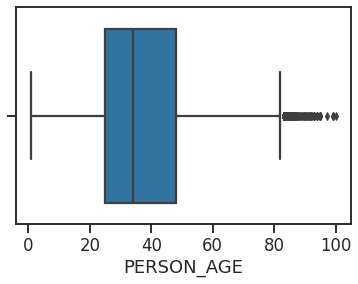

In [ ]:
sns.boxplot(df_NYC_util_FM['PERSON_AGE'])

In [ ]:
df_NYC_util_FM_Plot = px.box(df_NYC_util_FM, y='PERSON_AGE')
df_NYC_util_FM_Plot.show()

In [ ]:
df_NYC_util_Graf_2 = pd.DataFrame(df_NYC_util.resample('W')['PERSON_INJURY_BIN'].sum())
df_NYC_util_Graf_2.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 47 entries, 2021-01-03 to 2021-11-21
Freq: W-SUN
Data columns (total 1 columns):
 #   Column             Non-Null Count  Dtype
---  ------             --------------  -----
 0   PERSON_INJURY_BIN  47 non-null     int64
dtypes: int64(1)
memory usage: 752.0 bytes


In [ ]:
df_NYC_util_Graf_3 = pd.DataFrame(df_NYC_util.resample('W')['PERSON_SEX_BIN'].sum())
df_NYC_util_Graf_3.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 47 entries, 2021-01-03 to 2021-11-21
Freq: W-SUN
Data columns (total 1 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   PERSON_SEX_BIN  47 non-null     int64
dtypes: int64(1)
memory usage: 752.0 bytes


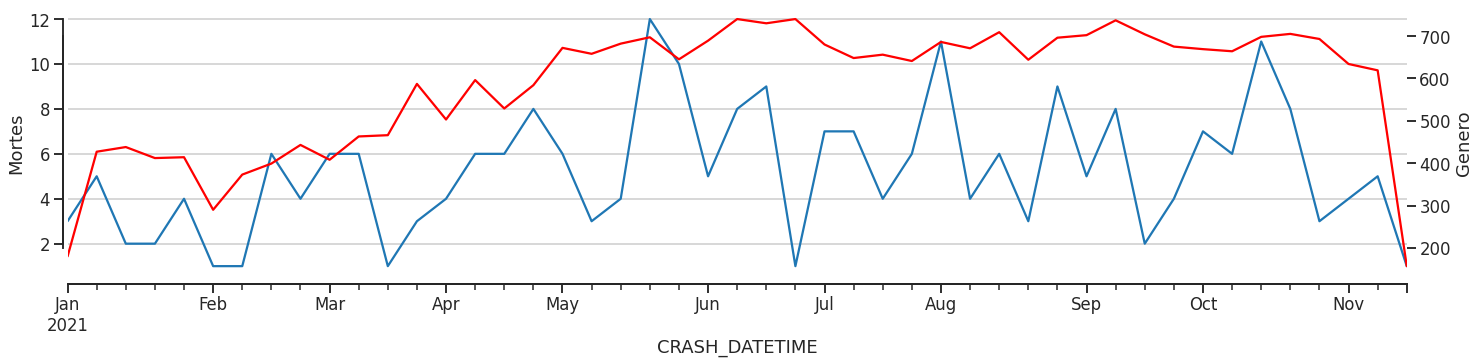

In [ ]:
ax = plot_series(df_NYC_util_Graf_2.PERSON_INJURY_BIN)
ax.set_ylabel("Mortes")
ax2 = ax.twinx()

df_NYC_util_Graf_3.PERSON_SEX_BIN.plot(ax=ax2, c="r")
ax2.set_ylabel("Genero")

sns.despine(trim=True, offset=5)


In [ ]:
df_graf = df_NYC_util_FM.groupby(['CRASH_DATE', 'PERSON_INJURY', 'PERSON_SEX'])['PERSON_AGE'].agg('mean')
df_graf

CRASH_DATE  PERSON_INJURY  PERSON_SEX
2021-01-01  Injured        F             38.725000
                           M             32.578125
            Killed         F             60.000000
                           M             57.000000
2021-01-02  Injured        F             35.605263
                                           ...    
2021-11-15  Injured        F             40.142857
                           M             38.500000
2021-11-16  Injured        F             34.212766
                           M             37.555556
            Killed         M             80.000000
Name: PERSON_AGE, Length: 829, dtype: float64

In [ ]:
df_NYC_util_FM['PERSON_AGE'].max()

100.0

In [ ]:
df_NYC_util_FM_copy = df_NYC_util_FM[df_NYC_util_FM['PERSON_INJURY'] == 'Killed']
df_NYC_util_FM_copy

,CRASH_DATE,CRASH_TIME,PERSON_INJURY,PERSON_AGE,PERSON_SEX,PERSON_TYPE,COMPLAINT,EMOTIONAL_STATUS,COLLISION_ID,PERSON_INJURY_BIN,PERSON_SEX_BIN
CRASH_DATETIME,,,,,,,,,,,
2021-05-21 00:00:00,2021-05-21,0:00,Killed,24.0,M,Occupant,Internal,Apparent Death,4419608,1,1
2021-10-15 02:00:00,2021-10-15,2:00,Killed,30.0,M,Occupant,Internal,Apparent Death,4467504,1,1
2021-04-17 13:00:00,2021-04-17,13:00,Killed,71.0,M,Pedestrian,Internal,Unconscious,4408062,1,1
2021-05-25 22:00:00,2021-05-25,22:00,Killed,69.0,F,Pedestrian,None Visible,Conscious,4420918,1,0
2021-04-08 23:00:00,2021-04-08,23:00,Killed,43.0,M,Pedestrian,Internal,Unconscious,4407069,1,1
...,...,...,...,...,...,...,...,...,...,...,...
2021-07-28 04:00:00,2021-07-28,4:00,Killed,32.0,M,Occupant,Severe Bleeding,Apparent Death,4441354,1,1
2021-09-02 10:00:00,2021-09-02,10:00,Killed,62.0,F,Pedestrian,Crush Injuries,Apparent Death,4453656,1,0
2021-05-22 04:00:00,2021-05-22,4:00,Killed,28.0,M,Occupant,Crush Injuries,Unconscious,4419561,1,1


In [ ]:
df_NYC_util_FM_copy['PERSON_INJURY'].count()

243

In [ ]:
fig = px.line(df_graf.reset_index(), x='CRASH_DATE', y='PERSON_AGE', title='Histórico de mortes por idade', color='PERSON_SEX')
fig.show()

In [ ]:
df_kill = df_graf.reset_index(inplace=False)
#df_kill.set_index('CRASH_DATE', inplace=True)
df_kill_fem = df_kill[(df_kill.PERSON_SEX == 'F')]
df_kill_fem

,CRASH_DATE,PERSON_INJURY,PERSON_SEX,PERSON_AGE
0,2021-01-01,Injured,F,38.725000
2,2021-01-01,Killed,F,60.000000
4,2021-01-02,Injured,F,35.605263
7,2021-01-03,Injured,F,33.489362
9,2021-01-04,Injured,F,41.075000
...,...,...,...,...
818,2021-11-13,Injured,F,35.740741
820,2021-11-14,Injured,F,38.041667
822,2021-11-14,Killed,F,56.000000
824,2021-11-15,Injured,F,40.142857


In [ ]:
df_kill_fem.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 377 entries, 0 to 826
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   CRASH_DATE     377 non-null    object 
 1   PERSON_INJURY  377 non-null    object 
 2   PERSON_SEX     377 non-null    object 
 3   PERSON_AGE     377 non-null    float64
dtypes: float64(1), object(3)
memory usage: 14.7+ KB


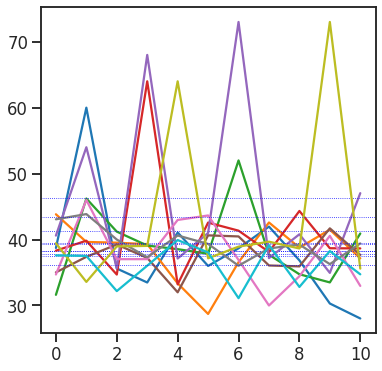

In [ ]:
fig, ax = plt.subplots(1, 1, figsize= (6, 6))

for idx in range(10):
    from_date = (idx * 12 )
    to_date = ((idx+1) * 12 - 1)
    values = df_kill_fem["PERSON_AGE"].iloc[from_date:to_date ].values
    ax.plot(values)
    ax.axhline(y=np.mean(values), color="b", lw=.8, ls=":")

In [ ]:
result = seasonal_decompose(df_kill_fem["PERSON_AGE"], period=12, model="multiplicative")

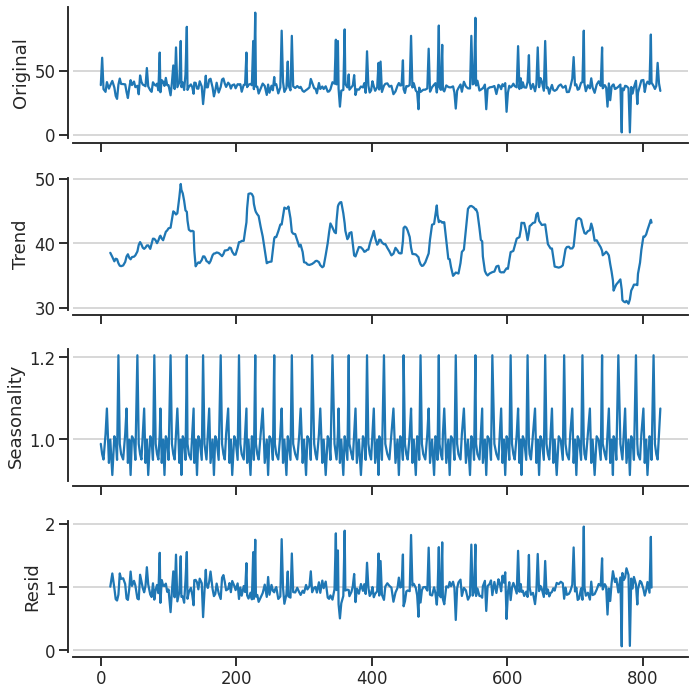

In [ ]:
fig, axes = plt.subplots(4, 1, figsize=(10, 10), sharex=True)


result.observed.plot(ax=axes[0])
axes[0].set_ylabel("Original")
axes[0].yaxis.grid(True)
result.trend.plot(ax=axes[1])
axes[1].yaxis.grid(True)

axes[1].set_ylabel("Trend")
result.seasonal.plot(ax=axes[2])
axes[2].set_ylabel("Seasonality")
axes[2].yaxis.grid(True)

result.resid.plot(ax=axes[3])
axes[3].set_ylabel("Resid")
axes[3].yaxis.grid(True)

sns.despine(offset=5, trim=False)
fig.tight_layout()

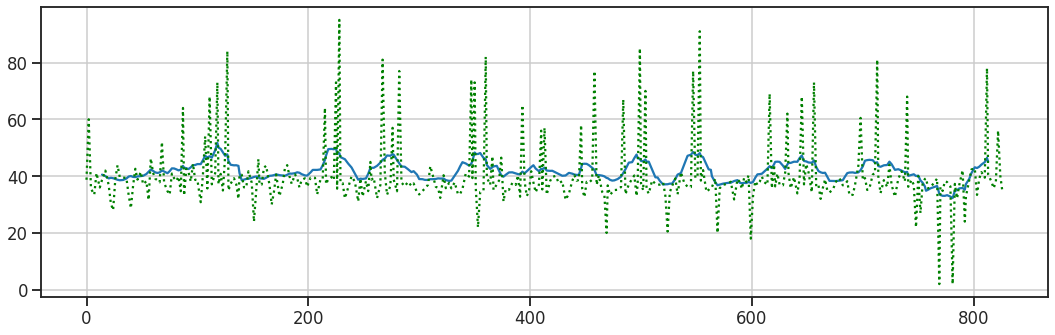

In [ ]:
indices_trend_null = result.trend.isna()

recomposition = (result.trend[~indices_trend_null] 
                 + result.seasonal[~indices_trend_null]
                 + result.resid[~indices_trend_null])

ax = recomposition.plot(figsize=(15,5))
df_kill_fem["PERSON_AGE"].plot(color="g", ls=":", ax=ax)

ax.grid(True)
fig = plt.gcf()
fig.tight_layout()

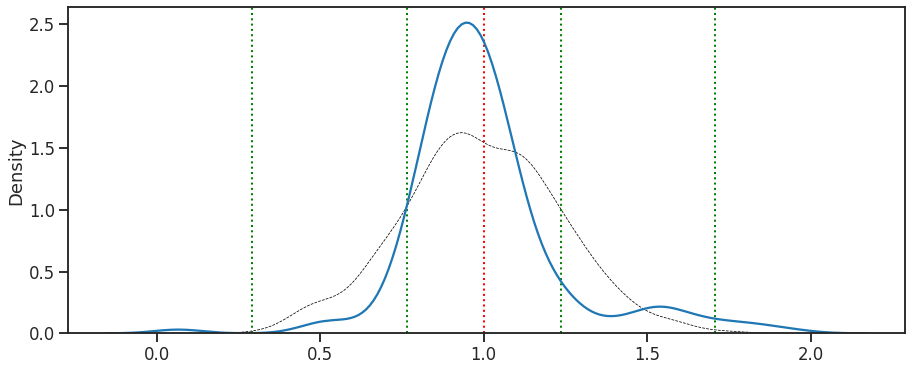

In [ ]:
fig, ax = plt.subplots( 1, 1, figsize=(15, 6))

sigma = np.nanstd(result.resid.values)
mu = np.nanmean(result.resid.values)
normal = np.random.normal(mu, sigma, 1000)
sns.kdeplot( normal, color='k', ls="--", lw=0.75)
ax.axvline(x=mu, color='red', lw=2, ls=":")

ax.axvline(x=mu + 1 * sigma, color='green', lw=2, ls=":")
ax.axvline(x=mu - 1 * sigma, color='green', lw=2, ls=":")

ax.axvline(x=mu + 3 * sigma, color='green', lw=2, ls=":")
ax.axvline(x=mu - 3 * sigma, color='green', lw=2, ls=":")

sns.kdeplot(result.resid.values, ax=ax)

In [ ]:
def print_adfuller_test(serie):
    test = adfuller(serie)
    print(f"Test: {test[0]:.2f} p-value: {test[1]:.3f}"
          f" criticals: <1% = {test[4]['1%']:.2f}  5% = {test[4]['5%']:.2f}"
          f" 10% = {test[4]['10%']:.2f} > ")

print_adfuller_test(df_kill_fem["PERSON_AGE"])

Test: -19.88 p-value: 0.000 criticals: <1% = -3.45  5% = -2.87 10% = -2.57 > 


Test: -8.14 p-value: 0.000 criticals: <1% = -3.45  5% = -2.87 10% = -2.57 > 


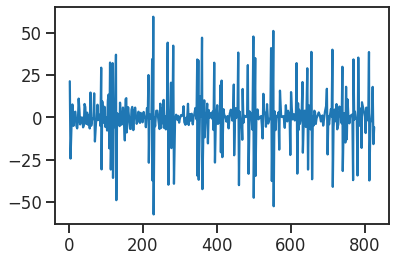

In [ ]:
serie_diff = df_kill_fem["PERSON_AGE"].diff()

serie_diff.dropna().plot()
print_adfuller_test(serie_diff.dropna())

Test: -8.54 p-value: 0.000 criticals: <1% = -3.45  5% = -2.87 10% = -2.57 > 


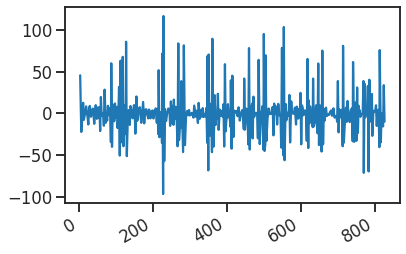

In [ ]:
fig, ax = plt.subplots(1,1)
serie_diff_2  = df_kill_fem["PERSON_AGE"].diff().shift(1) - df_kill_fem["PERSON_AGE"].diff()
ax = serie_diff_2.dropna().plot(ax=ax)
print_adfuller_test(serie_diff_2.dropna())

fig.autofmt_xdate()

Test: -8.32 p-value: 0.000 criticals: <1% = -3.45  5% = -2.87 10% = -2.57 > 


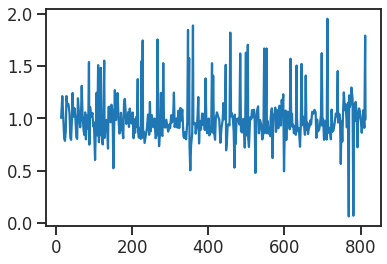

In [ ]:
result.resid.plot()
print_adfuller_test(result.resid.dropna())

In [ ]:
model = ARIMA(result.resid.dropna(), order=(2, 1, 2))
result_arima = model.fit()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning:

Maximum Likelihood optimizat

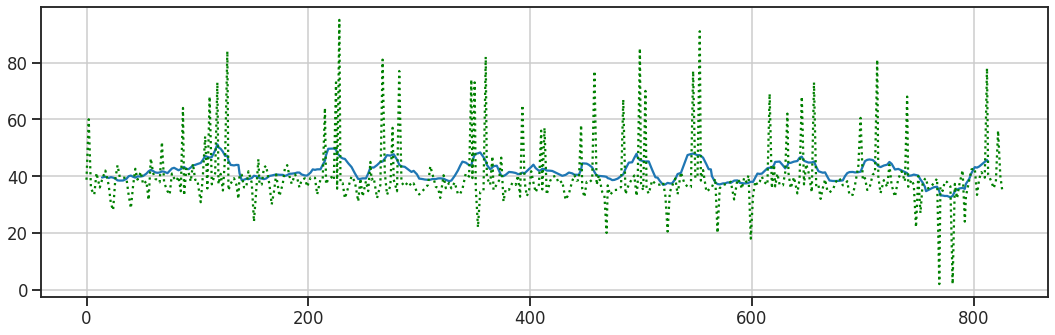

In [ ]:
fitted_values = result_arima.fittedvalues
indices_trend_null = result.trend.isna()

recomposition = (result.trend[~indices_trend_null] 
                 + result.seasonal[~indices_trend_null]
                 + fitted_values[~indices_trend_null])

ax = recomposition.plot(figsize=(15,5))
df_kill_fem["PERSON_AGE"].plot(color="g", ls=":", ax=ax)

ax.grid(True)
fig = plt.gcf()
fig.tight_layout()

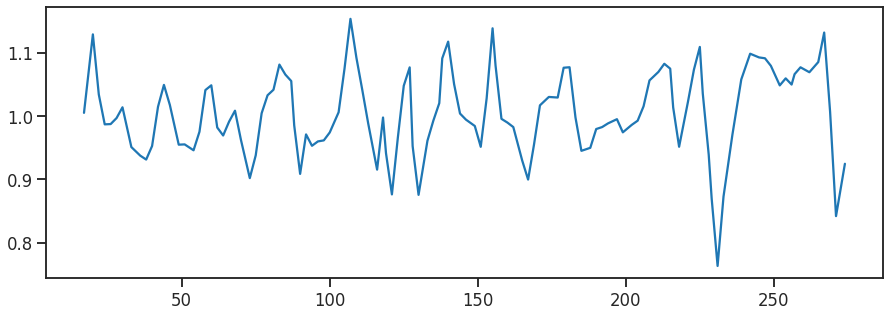

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
result_arima.predict(1, 1*1  + 10*12).plot(ax=ax)

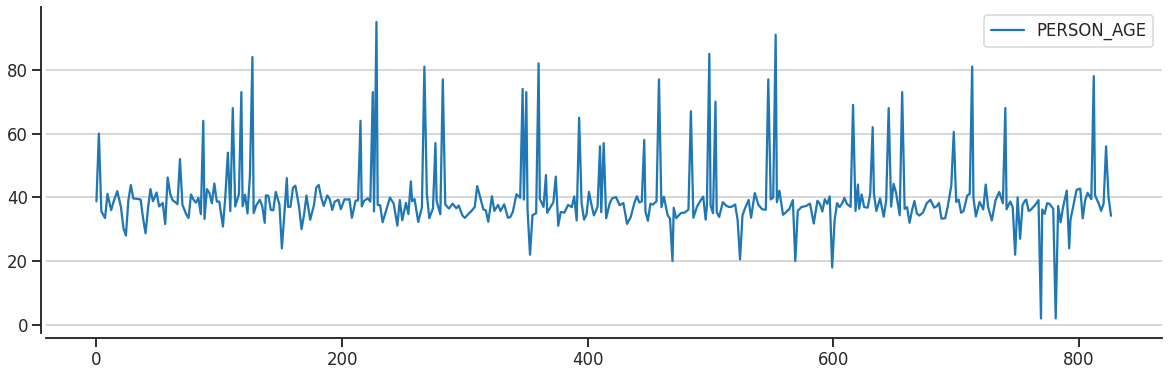

In [ ]:
fig, ax= plt.subplots(1, 1, figsize=(20, 6))
sns.set_style("ticks")
sns.set_context("talk")

df_kill_fem.plot(ax=ax)
ax.yaxis.grid(True)
sns.despine(offset=5, trim=False)

In [ ]:
df_kill_fem['PERSON_AGE'] = df_kill_fem['PERSON_AGE'].astype(int)
df_kill_fem

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,CRASH_DATE,PERSON_INJURY,PERSON_SEX,PERSON_AGE
0,2021-01-01,Injured,F,38
2,2021-01-01,Killed,F,60
4,2021-01-02,Injured,F,35
7,2021-01-03,Injured,F,33
9,2021-01-04,Injured,F,41
...,...,...,...,...
818,2021-11-13,Injured,F,35
820,2021-11-14,Injured,F,38
822,2021-11-14,Killed,F,56
824,2021-11-15,Injured,F,40


In [ ]:
df_kill_fem.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 377 entries, 0 to 826
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   CRASH_DATE     377 non-null    object
 1   PERSON_INJURY  377 non-null    object
 2   PERSON_SEX     377 non-null    object
 3   PERSON_AGE     377 non-null    int64 
dtypes: int64(1), object(3)
memory usage: 14.7+ KB


In [ ]:
df_NYC_janela = pd.DataFrame(df_NYC_util.resample('W')['PERSON_AGE'].sum())
df_NYC_janela.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 47 entries, 2021-01-03 to 2021-11-21
Freq: W-SUN
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   PERSON_AGE  47 non-null     float64
dtypes: float64(1)
memory usage: 752.0 bytes


In [ ]:
adf = ADFTest()
adf.is_stationary(df_NYC_util_Graf_3)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning:

is_stationary is deprecated and will be removed in a future release of pmdarima. Use should_diff instead.



(0.99, True)

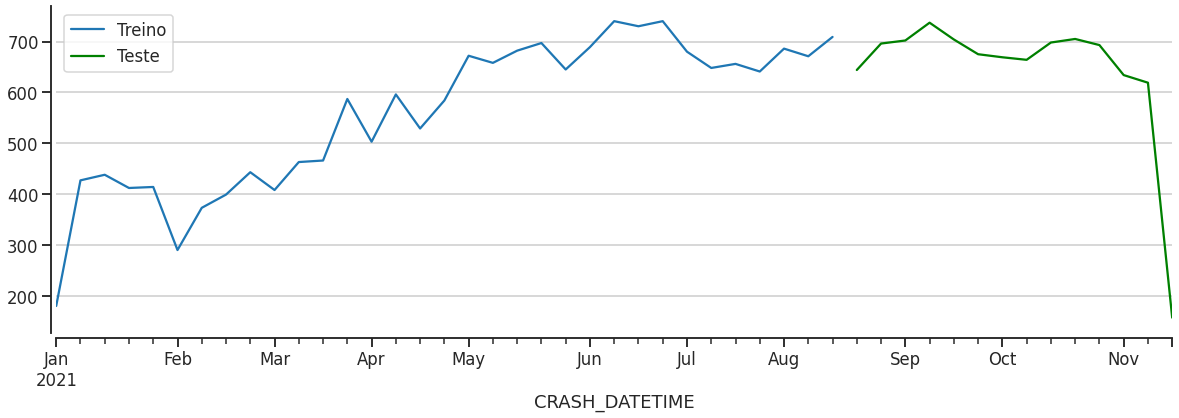

In [ ]:
size_of_train = int(np.ceil(df_NYC_util_Graf_3.shape[0] * 0.70))
train = df_NYC_util_Graf_3.iloc[:size_of_train]
test = df_NYC_util_Graf_3.iloc[size_of_train:]

fig, ax= plt.subplots(1, 1, figsize=(20, 6))
sns.set_style("ticks")
sns.set_context("talk")

train.plot(ax=ax)
test.plot(ax=ax, c="g")
ax.yaxis.grid(True)
ax.legend(["Treino", "Teste"])
sns.despine(offset=5, trim=False)

In [ ]:
model = auto_arima(train,
                   start_p=1,
                   start_q=1,
                   max_p=8,
                   max_q=8,
                   m=12,
                   d=1,
                   D=1,
                   seasonal=True,
                   stepwise=False,
                   random_state=20,
                   n_fits=30)

In [ ]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                   33
Model:             SARIMAX(0, 1, 0)x(1, 1, 0, 12)   Log Likelihood                -120.195
Date:                            Tue, 29 Mar 2022   AIC                            244.389
Time:                                    11:51:09   BIC                            246.381
Sample:                                         0   HQIC                           244.778
                                             - 33                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12      -0.6222      0.162     -3.850      0.000      -0.939      -0.305
sigma2      7305.8930   2674.087      2.732      0.006    2064.779    1.25e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.19   Jarque-Bera (JB):                 4.77
Prob(Q):                              0.66   Prob(JB):                         0.09
Heteroskedasticity (H):               0.12   Skew:                            -0.66
Prob(H) (two-sided):                  0.01   Kurtosis:                         5.00
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
model.fit(train)

ARIMA(order=(0, 1, 0), scoring_args={}, seasonal_order=(1, 1, 0, 12),
      suppress_warnings=True, with_intercept=False)

In [ ]:
y_predict = model.predict(n_periods = len(test))

In [ ]:
y_predict_df = pd.Series(y_predict, index=test.index)
y_predict_df

CRASH_DATETIME
2021-08-22    667.577921
2021-08-29    718.422458
2021-09-05    739.555387
2021-09-12    811.067600
2021-09-19    762.577921
2021-09-26    797.779207
2021-10-03    744.001135
2021-10-10    781.245974
2021-10-17    830.335729
2021-10-24    838.624122
2021-10-31    847.891117
2021-11-07    871.579812
2021-11-14    823.575827
2021-11-21    870.161483
Freq: W-SUN, dtype: float64

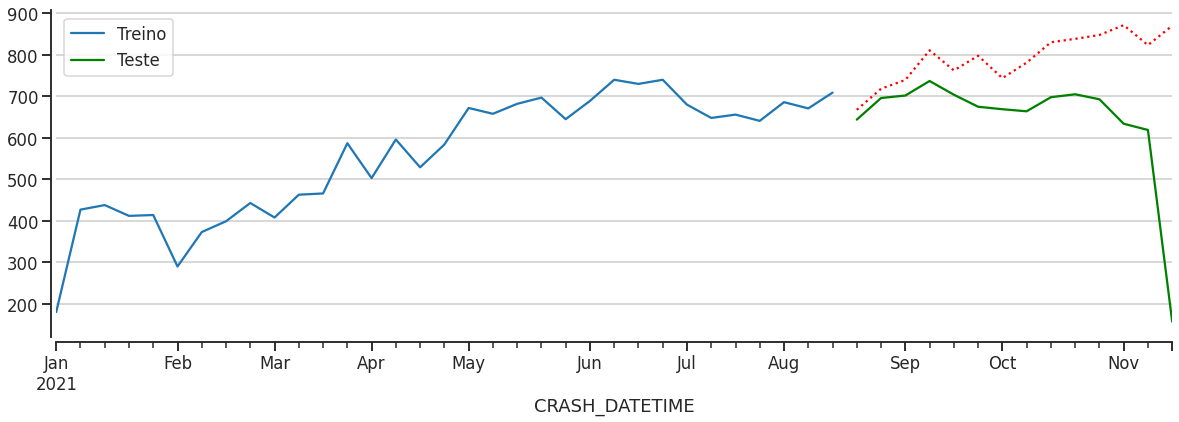

In [ ]:
fig, ax= plt.subplots(1, 1, figsize=(20, 6))
sns.set_style("ticks")
sns.set_context("talk")

train.plot(ax=ax)
test.plot(ax=ax, c="g")
y_predict_df.plot(ax=ax, c="r", ls=":")

ax.yaxis.grid(True)
ax.legend(["Treino", "Teste"])
sns.despine(offset=5, trim=False)

In [ ]:
print("R2 Score: ", r2_score(test, y_predict_df[test.index]))
print("MSE: ", mean_squared_error(test, y_predict_df))
print("RMSE: ", mean_squared_error(test, y_predict_df, squared=False))

R2 Score:  -1.6649048939265199
MSE:  50863.36734659
RMSE:  225.52908315024473


In [ ]:
df_NYC_util_Graf_3

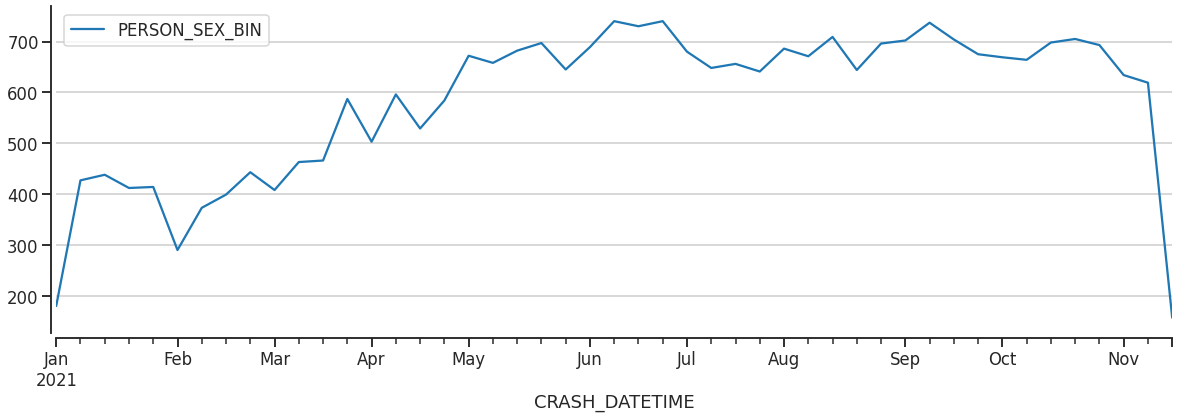

In [ ]:
fig, ax= plt.subplots(1, 1, figsize=(20, 6))
sns.set_style("ticks")
sns.set_context("talk")

df_NYC_util_Graf_3.plot(ax=ax)
ax.yaxis.grid(True)
sns.despine(offset=5, trim=False)

In [ ]:
train_prophet = train.reset_index().rename(columns={'CRASH_DATETIME': 'ds', 'PERSON_SEX_BIN': 'y'})
train_prophet.head()

,ds,y
0,2021-01-03,180
1,2021-01-10,427
2,2021-01-17,438
3,2021-01-24,412
4,2021-01-31,414


In [ ]:
model = Prophet()
model.fit(train_prophet)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/usr/local/lib/python3.7/dist-packages/fbprophet/forecaster.py:401: DeprecationWarning:

`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



In [ ]:
periods = df_NYC_util_Graf_3.shape[0] - size_of_train
future = model.make_future_dataframe(periods=periods, freq="MS")
forecast = model.predict(future)

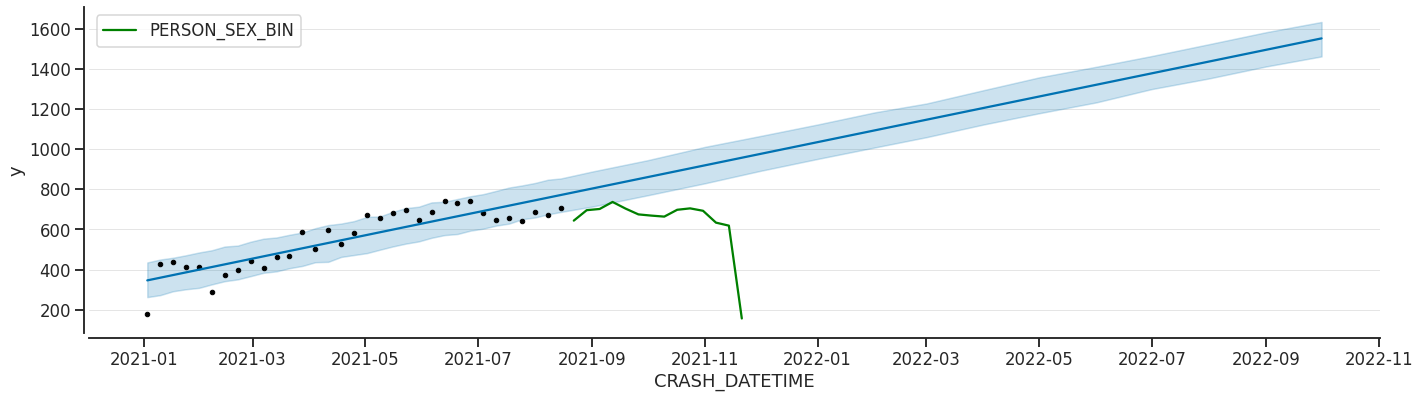

In [ ]:
fig, ax= plt.subplots(1, 1, figsize=(20, 6))
sns.set_style("ticks")

sns.set_context("talk")
model.plot(forecast, ax=ax);

test.plot(ax=ax, c="g");
ax.yaxis.grid(True)

sns.despine(offset=5, trim=False)

In [ ]:
yhat_test = forecast.yhat[size_of_train:]

print("R2 Score: ", r2_score(test, yhat_test))
print("MSE: ", mean_squared_error(test, yhat_test))
print("RMSE: ", mean_squared_error(test, yhat_test, squared=False))

R2 Score:  -19.501310344856968
MSE:  391295.6449340583
RMSE:  625.5362858652232


In [ ]:
model = Prophet(yearly_seasonality=1, seasonality_mode="multiplicative")
model.fit(train_prophet)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/usr/local/lib/python3.7/dist-packages/fbprophet/forecaster.py:434: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

/usr/local/lib/python3.7/dist-packages/fbprophet/forecaster.py:401: DeprecationWarning:

`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you 

In [ ]:
future = model.make_future_dataframe(periods=periods, freq="W")
forecast = model.predict(future)

/usr/local/lib/python3.7/dist-packages/fbprophet/forecaster.py:434: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



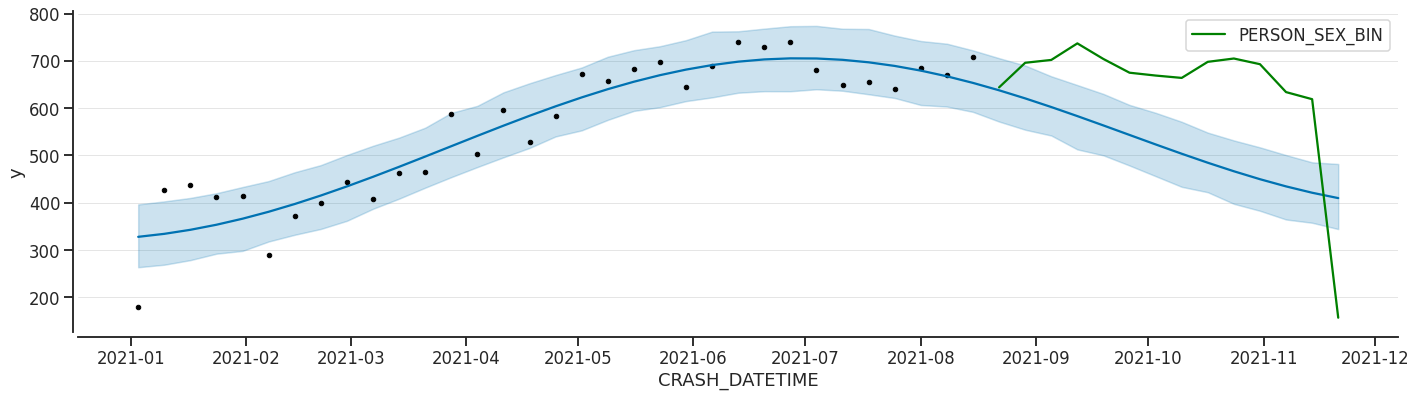

In [ ]:
fig, ax= plt.subplots(1, 1, figsize=(20, 6))
sns.set_style("ticks")

sns.set_context("talk")
model.plot(forecast, ax=ax);

test.plot(ax=ax, c="g");
ax.yaxis.grid(True)

sns.despine(offset=5, trim=False)

In [ ]:
yhat_test = forecast.yhat[size_of_train:]

print("R2 Score: ", r2_score(test, yhat_test))
print("MSE: ", mean_squared_error(test, yhat_test))
print("RMSE: ", mean_squared_error(test, yhat_test, squared=False))

R2 Score:  -0.5997683312550524
MSE:  30533.774202416484
RMSE:  174.73916047187728


In [ ]:
far_future = model.make_future_dataframe(periods=3 * periods, freq="W")
far_forecast = model.predict(far_future)

/usr/local/lib/python3.7/dist-packages/fbprophet/forecaster.py:434: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



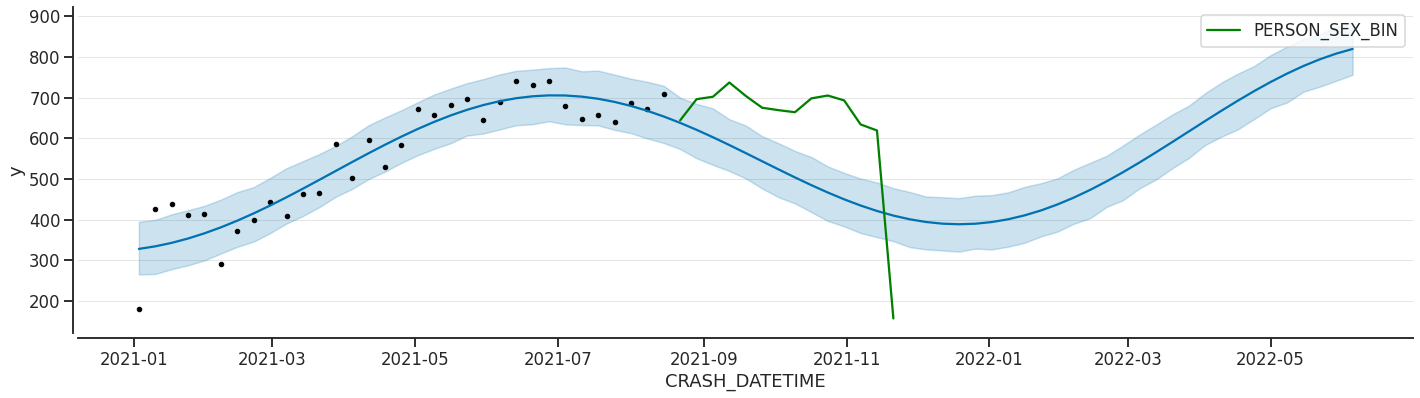

In [ ]:
fig, ax= plt.subplots(1, 1, figsize=(20, 6))
sns.set_style("ticks")

sns.set_context("talk")
model.plot(far_forecast, ax=ax);

test.plot(ax=ax, c="g");
ax.yaxis.grid(True)

sns.despine(offset=5, trim=False)

In [ ]:
yhat_test = forecast.yhat[size_of_train:]

print("R2 Score: ", r2_score(test, yhat_test))
print("MSE: ", mean_squared_error(test, yhat_test))
print("RMSE: ", mean_squared_error(test, yhat_test, squared=False))

R2 Score:  -0.5997683312550524
MSE:  30533.774202416484
RMSE:  174.73916047187728
